**Semantic Segmentation:** In one line, it is pixel-wise classification. The deep learning model we use here is UNET model designed for Biomedical Image Segmentation originally proposed in the paper entitled:
*U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger, Philipp Fischer, Thomas Brox*. 

The advantage of this model over other models is that it does not require many thousand annotated images as training samples. It is pure convolutional network and does not consist of any fully-connected layer. The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.

**Dataset Description:** The dataset consists of car images. Each image has just one car. We are provided with the binary mask of each image which serves as label and is used in training the model.
We use 1000 images in training dataset.

In [0]:
!pip install -U -q PyDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path_of_data = '/content/drive/give_your_path_if_using_Colab'

!ls {path_of_data}

 epochs_loss.png    Task2	  train_mask	    train.zip
 model-car.h5	    train	  trainmask_A	    UNET_study.ipynb
'More Images.zip'   train_A	  trainmask_A.zip
 salt-challenge     train_A.zip   train_mask.zip


In [0]:
import pickle as p
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [5]:
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [7]:
#Here I provide a path for the dataset stored in the folder "train"
fpath = '/content/drive/give_your_path_if_using_Colab'
ids = os.listdir(fpath) #fpath is where the images are stored. We obtain their ids
#print(ids)
print(len(ids))

1000


In [8]:
#Here I provide a path for the dataset stored in the folder "train_mask"
fpath_mask = '/content/drive/give_your_path_if_using_Colab'
ids_masks = os.listdir(fpath_mask)
print(len(ids_masks))

1000


In [0]:
nums = len(ids) #number of images in the dataset
X = np.zeros((nums, im_height, im_width, 1), dtype=np.float32)
nums = len(ids_masks)
y = np.zeros((nums, im_height, im_width, 1), dtype=np.float32) #just some place holders

In [10]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    
    #read image and convert to array
    img = load_img(fpath+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    
    #take the label of image, transform it to the label of its mask
    id_to_list = id_.split(".", 1)
    mask_label = "_mask.gif"
    id_to_list[1] = mask_label
    mask_id = "";
    mask_id = mask_id.join(id_to_list)

    #use this transformed id to locate the corresponding mask in the next folder
    mask = load_img(fpath_mask+mask_id, grayscale=True)
    mask_array = img_to_array(mask)
    mask_array = resize(mask_array, (128, 128, 1), mode = 'constant', preserve_range = True)
    
    # Save images
    X[n] = x_img/255.0
    y[n] = mask_array/255.0

    print(n, id_, mask_id)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


0 0ee135a3cccc_15.jpg 0ee135a3cccc_15_mask.gif
1 0ee135a3cccc_14.jpg 0ee135a3cccc_14_mask.gif
2 0ee135a3cccc_13.jpg 0ee135a3cccc_13_mask.gif
3 0ee135a3cccc_16.jpg 0ee135a3cccc_16_mask.gif
4 0ee135a3cccc_12.jpg 0ee135a3cccc_12_mask.gif
5 0ee135a3cccc_11.jpg 0ee135a3cccc_11_mask.gif
6 0ee135a3cccc_10.jpg 0ee135a3cccc_10_mask.gif
7 0ee135a3cccc_09.jpg 0ee135a3cccc_09_mask.gif
8 0ee135a3cccc_08.jpg 0ee135a3cccc_08_mask.gif
9 0ee135a3cccc_07.jpg 0ee135a3cccc_07_mask.gif
10 0ee135a3cccc_06.jpg 0ee135a3cccc_06_mask.gif
11 0ee135a3cccc_05.jpg 0ee135a3cccc_05_mask.gif
12 0ee135a3cccc_04.jpg 0ee135a3cccc_04_mask.gif
13 0ee135a3cccc_03.jpg 0ee135a3cccc_03_mask.gif
14 0ee135a3cccc_02.jpg 0ee135a3cccc_02_mask.gif
15 0ee135a3cccc_01.jpg 0ee135a3cccc_01_mask.gif
16 0ed6904e1004_16.jpg 0ed6904e1004_16_mask.gif
17 0ed6904e1004_15.jpg 0ed6904e1004_15_mask.gif
18 0ed6904e1004_14.jpg 0ed6904e1004_14_mask.gif
19 0ed6904e1004_13.jpg 0ed6904e1004_13_mask.gif
20 0ed6904e1004_12.jpg 0ed6904e1004_12_mask.gif
21

In [11]:
print(X.shape)
print(y.shape)
print(X[0, ..., 0].shape)

(1000, 128, 128, 1)
(1000, 128, 128, 1)
(128, 128)


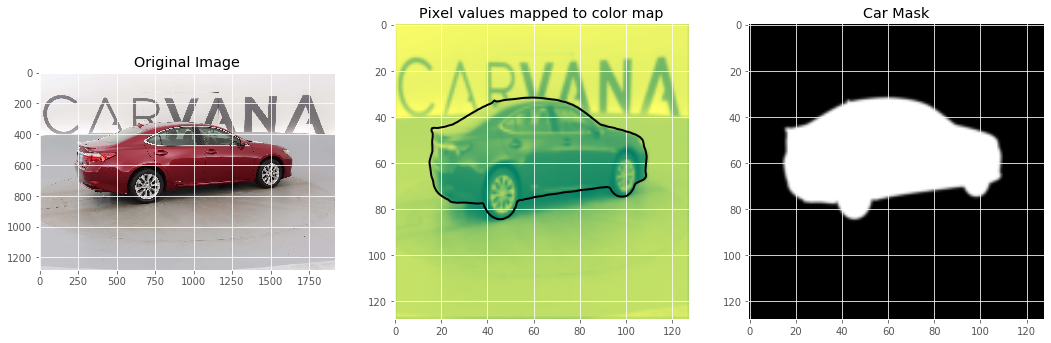

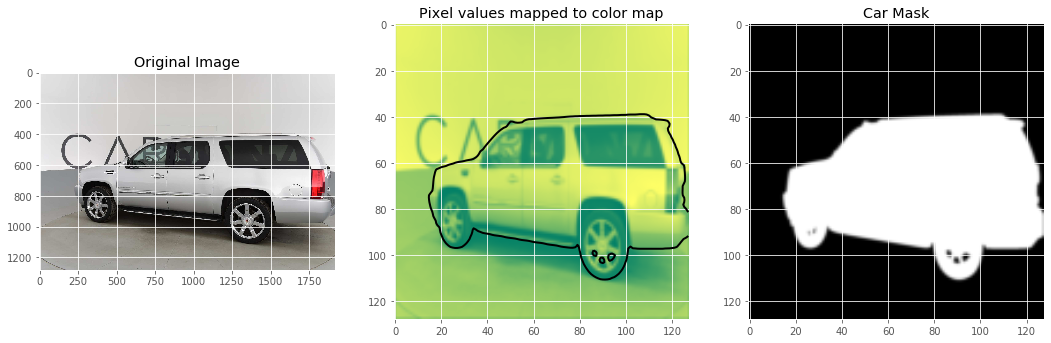

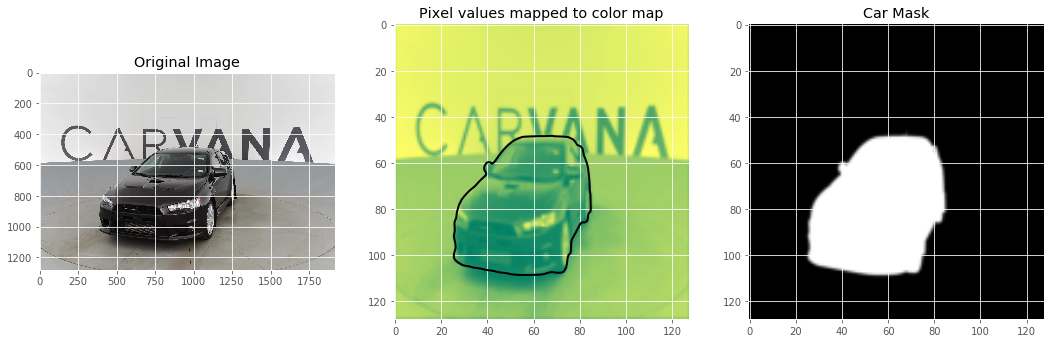

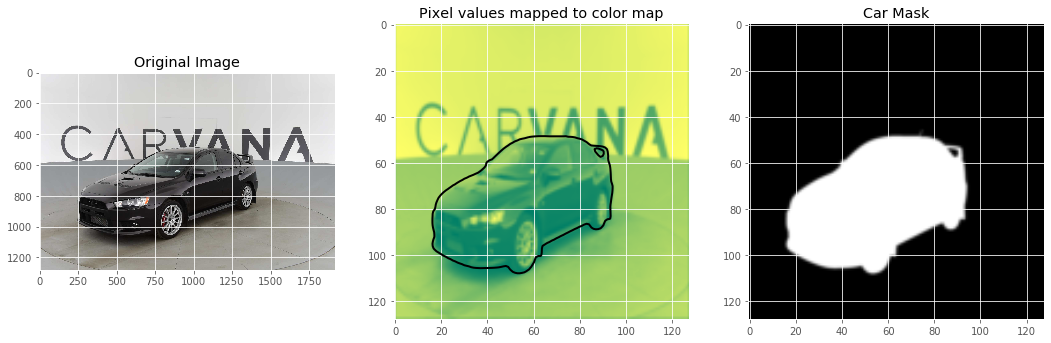

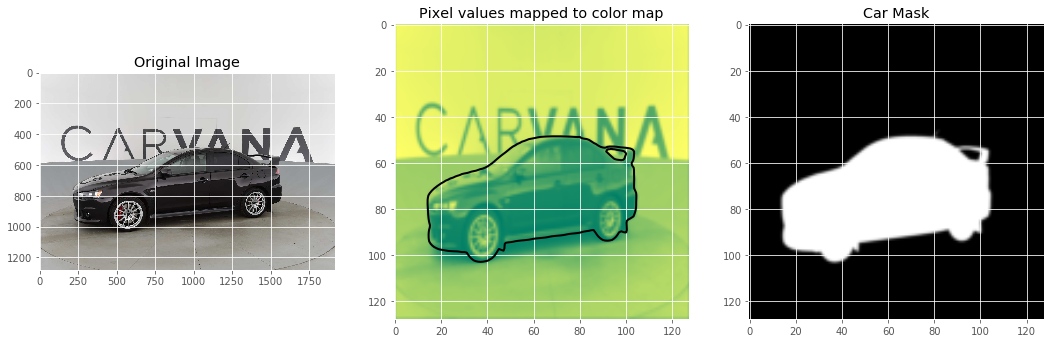

In [37]:

for i in range(0, 5):
  #i = random.randint(0, len(X)-1)
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 12))
  car = imread(fpath+ids[i]);
  ax1. imshow(car)
  ax1.set_title('Original Image')

  ax2.imshow(X[i, ..., 0], cmap = 'summer' , interpolation = 'bilinear')
  ax2.contour(y[i].squeeze(), colors = 'k', linewidths = 2, levels = [0.5])
  ax2.set_title('Pixel values mapped to color map')
  
  ax3.imshow(y[i].squeeze(), cmap = 'gray', interpolation = 'bilinear')
  ax3.set_title('Car Mask')

In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=0)

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
input_img = Input((im_height, im_width, 1), name='Image')

In [16]:
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image (InputLayer)              (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         Image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-car-weights-new.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [19]:
results = model.fit(X_train, y_train, batch_size=20, epochs=30, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))



Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 199s 249ms/step - loss: 0.4593 - acc: 0.8013 - val_loss: 0.3745 - val_acc: 0.9010

Epoch 00001: val_loss improved from inf to 0.37448, saving model to model-car-weights-new.h5
Epoch 2/30
800/800 [==============================] - 194s 242ms/step - loss: 0.2521 - acc: 0.9272 - val_loss: 0.2641 - val_acc: 0.9213

Epoch 00002: val_loss improved from 0.37448 to 0.26409, saving model to model-car-weights-new.h5
Epoch 3/30
800/800 [==============================] - 194s 242ms/step - loss: 0.1911 - acc: 0.9288 - val_loss: 0.2330 - val_acc: 0.9108

Epoch 00003: val_loss improved from 0.26409 to 0.23299, saving model to model-car-weights-new.h5
Epoch 4/30
800/800 [==============================] - 193s 241ms/step - loss: 0.1462 - acc: 0.9295 - val_loss: 0.1647 - val_acc: 0.9229

Epoch 00004: val_loss improved from 0.23299 to 0.16470, saving model to model-car-weights-new.h5
Epoch 5/30
800/800 [

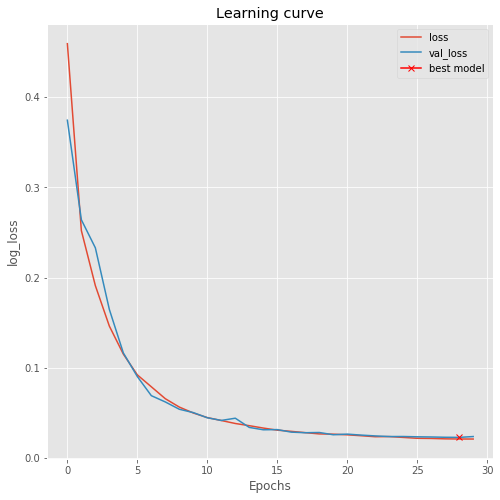

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig( "epochs_loss.png")

In [0]:
from google.colab import files
files.download('model-car-weights-new.h5') 

In [0]:
files.download( "epochs_loss.png" )

In [0]:
model.load_weights('/content/drive/give_your_path_if_using_Colab/model-car-weights-new.h5')

In [31]:
model.evaluate(X_valid, y_valid, verbose=1)

200/200 [==============================] - 13s 64ms/step


[0.023749100565910338, 0.9306924438476563]

In [32]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

200/200 [==============================] - 13s 64ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

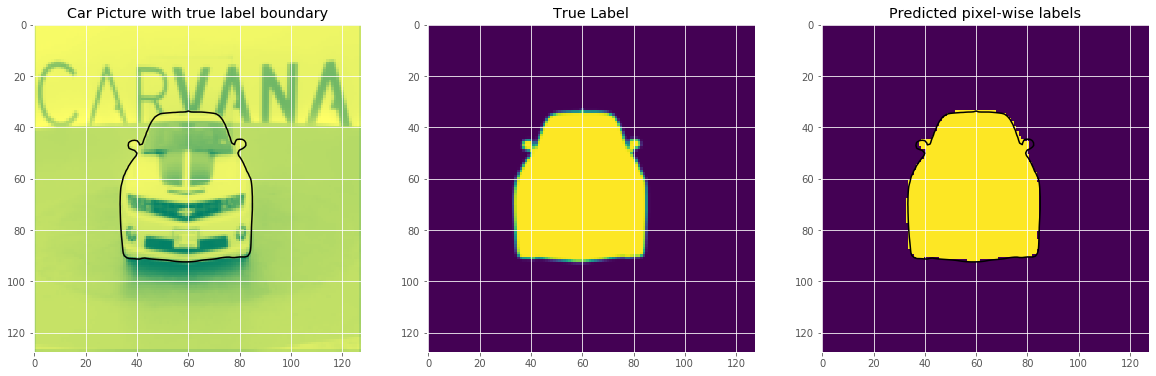

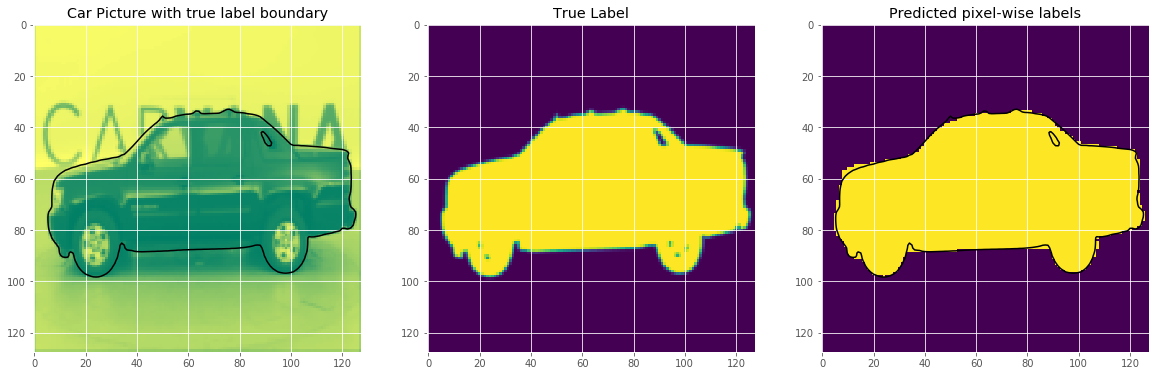

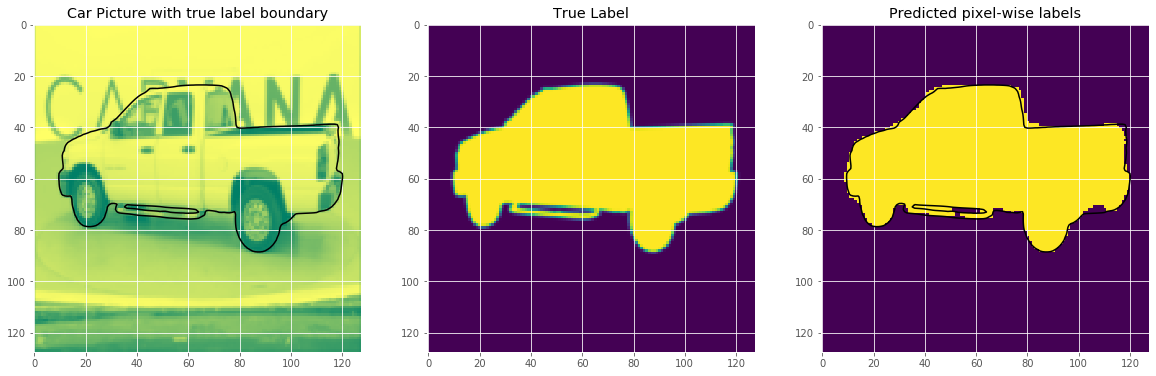

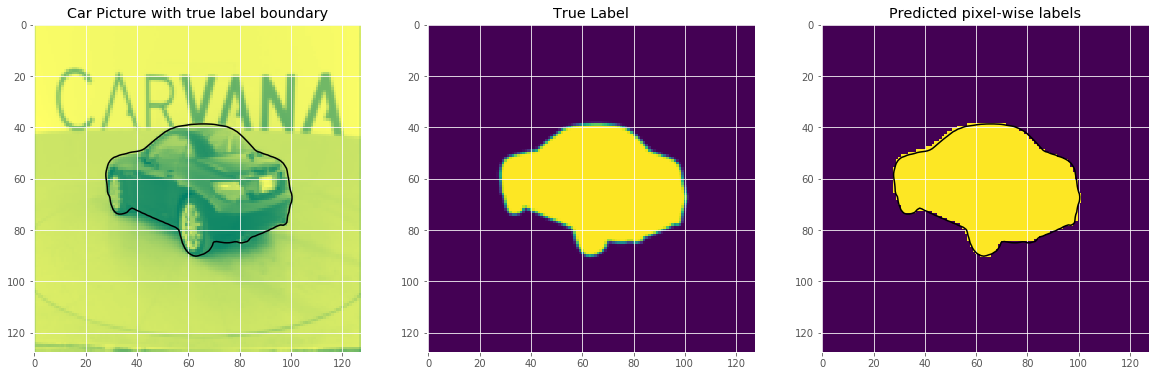

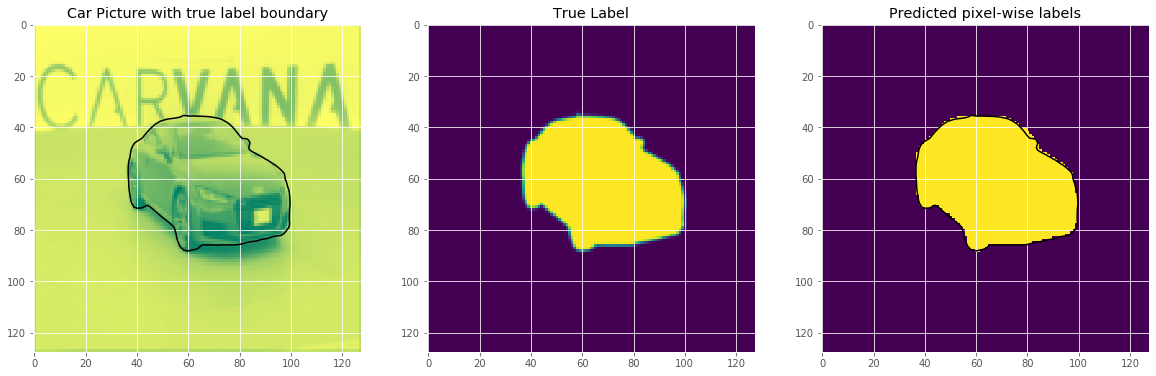

In [34]:

for ix in range(0, 5):

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    ax[0].imshow(X_valid[ix, ..., 0], cmap='summer')
    ax[0].contour(y_valid[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Car Picture with true label boundary')

    ax[1].imshow(y_valid[ix].squeeze())
    ax[1].set_title('True Label')

    ax[2].imshow(preds_val_t[ix].squeeze(), vmin=0, vmax=1)
    ax[2].contour(y_valid[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted pixel-wise labels')

Now let's load the model and make predicitions on the Test data.

**Predictions on Test data**

In [39]:
test_path = '/content/drive/give_your_path_if_using_Colab'
!ls {test_path}

0cdf5b5d0ce1_01.jpg  0cdf5b5d0ce1_08.jpg  0cdf5b5d0ce1_15.jpg
0cdf5b5d0ce1_02.jpg  0cdf5b5d0ce1_09.jpg  0cdf5b5d0ce1_16.jpg
0cdf5b5d0ce1_03.jpg  0cdf5b5d0ce1_10.jpg  0ce66b539f52_01.jpg
0cdf5b5d0ce1_04.jpg  0cdf5b5d0ce1_11.jpg  0ce66b539f52_02.jpg
0cdf5b5d0ce1_05.jpg  0cdf5b5d0ce1_12.jpg  0ce66b539f52_03.jpg
0cdf5b5d0ce1_06.jpg  0cdf5b5d0ce1_13.jpg  0ce66b539f52_04.jpg
0cdf5b5d0ce1_07.jpg  0cdf5b5d0ce1_14.jpg


In [0]:
#Here I provide a path for the dataset stored in the folder "train"
test_path = '/content/drive/give_your_path_if_using_Colab'
ids = os.listdir(test_path) #fpath is where the images are stored. We obtain their ids

n_test = len(ids)

In [0]:
X_test = np.zeros((n_test, im_height, im_width, 1), dtype=np.float32)

In [50]:
X_test.shape

(20, 128, 128, 1)

In [51]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    
    #read image and convert to array
    img = load_img(fpath+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    
    # Save images
    X_test[n] = x_img/255.0

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [52]:
preds_test = model.predict(X_test, verbose=1)

20/20 [==============================] - 1s 67ms/step


In [0]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

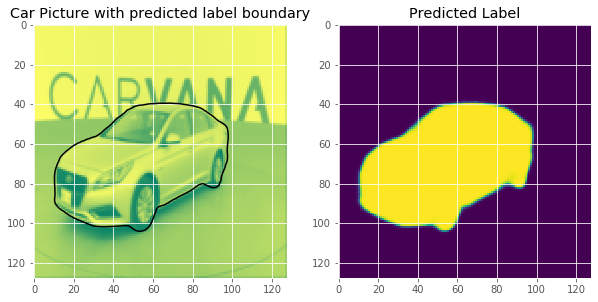

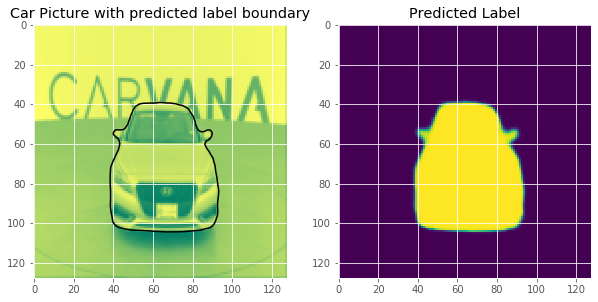

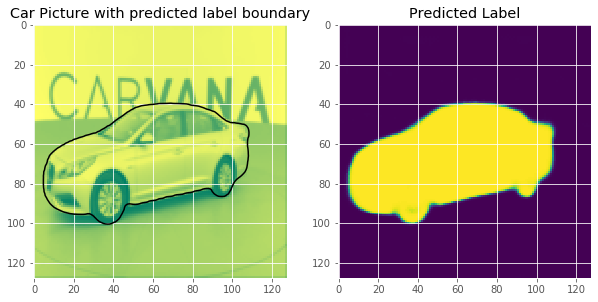

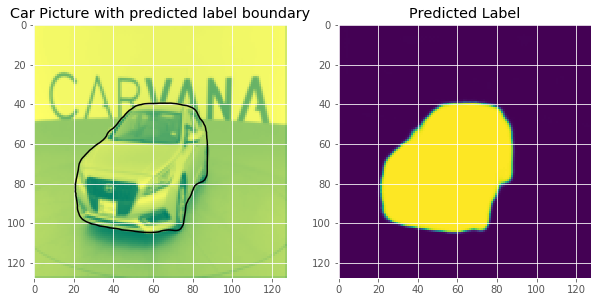

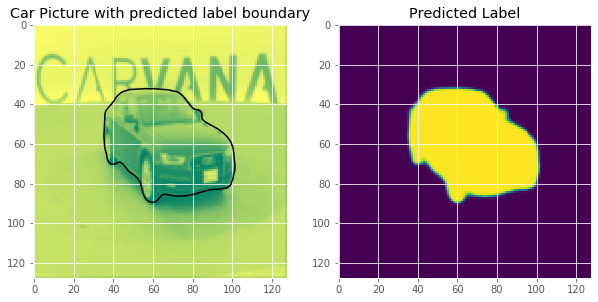

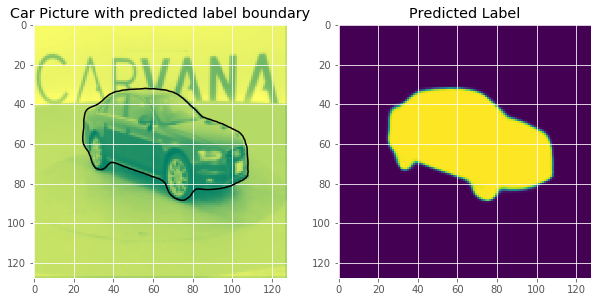

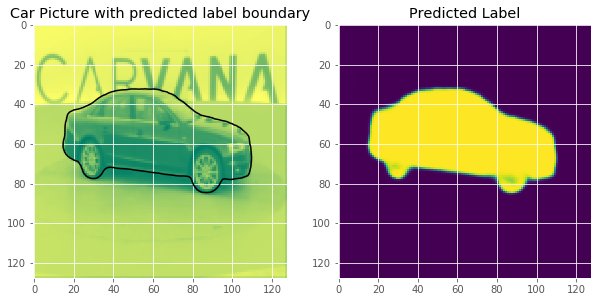

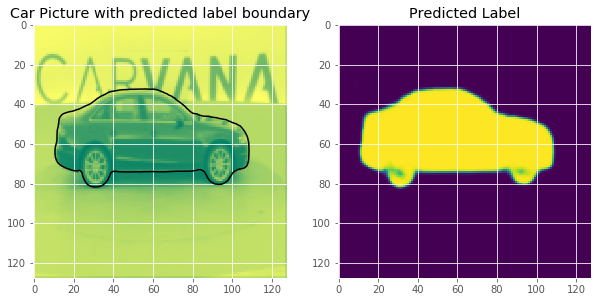

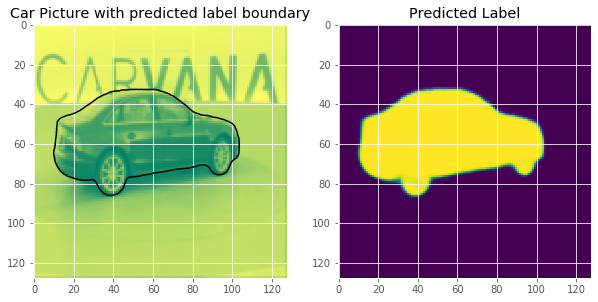

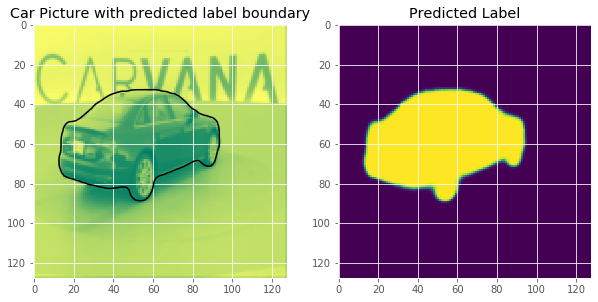

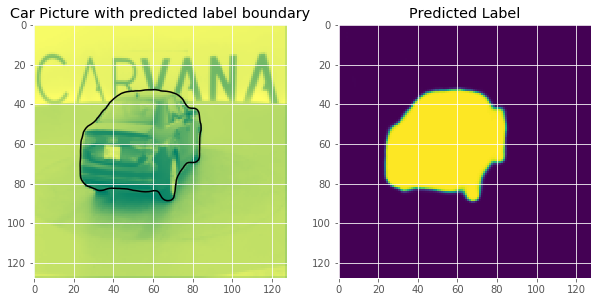

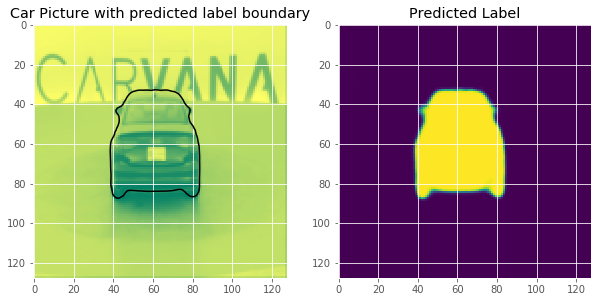

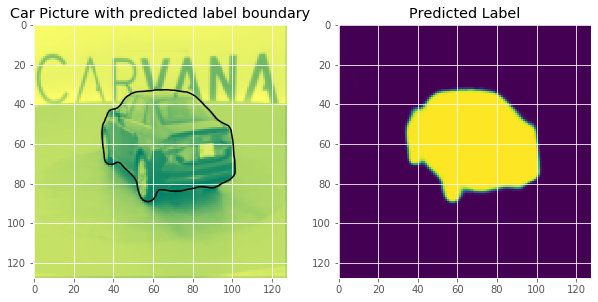

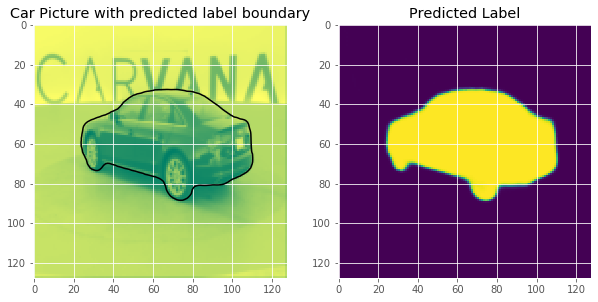

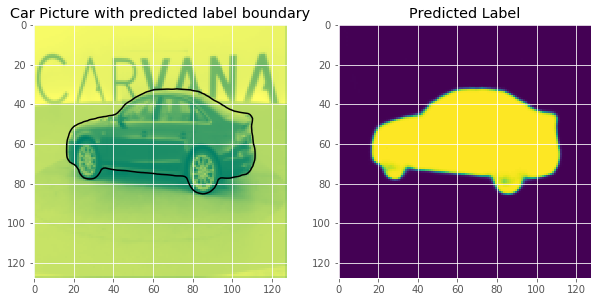

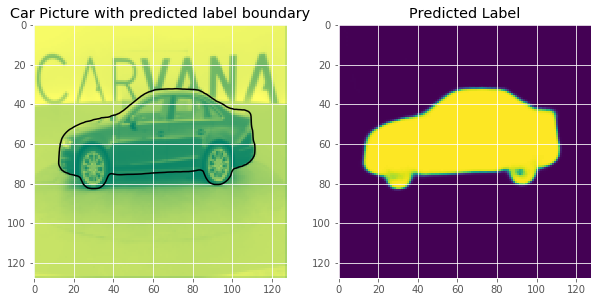

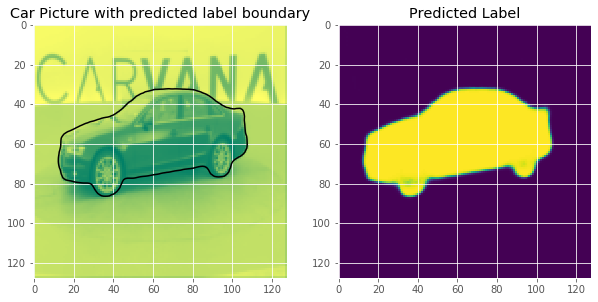

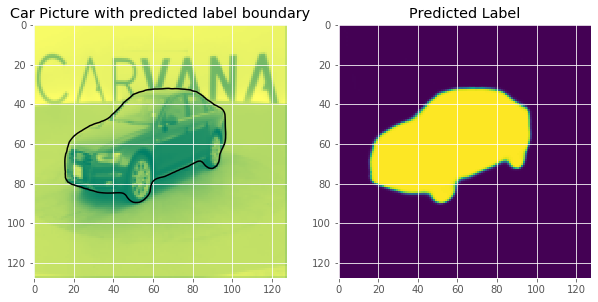

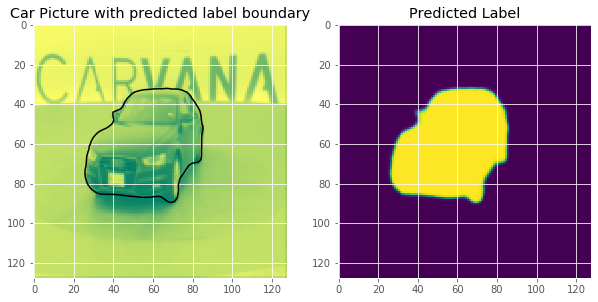

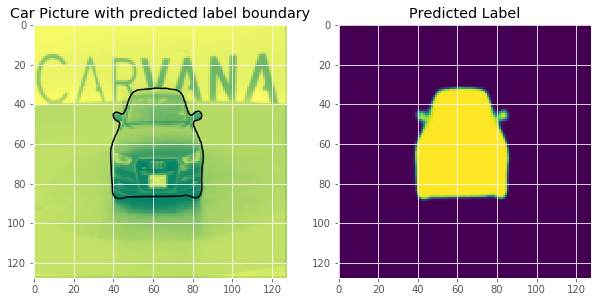

In [56]:
for ix in range(0, n_test):

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    
    ax[0].imshow(X_test[ix, ..., 0], cmap='summer')
    ax[0].contour(preds_test[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Car Picture with predicted label boundary')

    ax[1].imshow(preds_test[ix].squeeze())
    ax[1].set_title('Predicted Label')